In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

from main import *
%matplotlib inline

In [2]:
# Compute Camera Calibration Matrix
def cal_calib_points(filepath):
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2]  = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    objpoints = [] # 3d points in real world
    imgpoints = [] # 2d points in image plane

    images = glob.glob(filepath)

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

# Apply distortation on raw images
def cal_undistort(img, objp, imgp):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, gray.shape[::-1], None, None)

    if ret:
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        return dst
    else:
        return None

# Compute thresholded b-images
def hls_thresh(img, thresh=(0, 255)):
    # Get S Channel from the HLS image
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    sbin = np.zeros_like(s_channel)
    sbin[(s_channel>=thresh[0]) & (s_channel<=thresh[1])] = 1

    return sbin

def cal_sobel(img, sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(gray, -1, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, -1, 0, 1, ksize=sobel_kernel)

    return sobelx, sobely

def sobel_thresh(sobel, thresh=(0, 255)):
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    sbin = np.zeros_like(scaled_sobel)
    sbin[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])] = 1

    return sbin

def mag_thresh(sobelx, sobely, thresh=(0, 255)):
    gradmag = np.sqrt(sobelx**2+sobely**2)
    gradmag = np.uint8(255*gradmag/np.max(gradmag))

    sbin = np.zeros_like(gradmag)
    sbin[(gradmag>=thresh[0])&(gradmag<=thresh[1])] = 1

    return sbin

def dir_thresh(sobelx, sobely, thresh=(0, np.pi/2)):
    absgraddir = np.arctan2(np.absolute(sobelx), np.absolute(sobely))

    sbin = np.zeros_like(absgraddir)
    sbin[(absgraddir>=thresh[0])&(absgraddir<=thresh[1])] = 1

    return sbin

def cal_thresh_img(img, thresh_s, thresh_sx, thresh_sy, thresh_mag, thresh_gdir):
    sobel_kernel = 3
    sobelx, sobely = cal_sobel(img, sobel_kernel)

    hls = hls_thresh(img, thresh_s)
    sobx = sobel_thresh(sobelx, thresh_sx)
    soby = sobel_thresh(sobely, thresh_sy)
    mag = mag_thresh(sobelx, sobely, thresh_mag)
    
    sobelx, sobely = cal_sobel(img, sobel_kernel=15)
    gdir = dir_thresh(sobelx, sobely, thresh_gdir)

    combined = np.zeros_like(hls)
    combined[(((sobx==1)&(soby==1)|((mag==1)&(gdir==1))))&(hls==1)] = 1

    return combined

# Apply a perspective transform to rectify binary image
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped


In [4]:
# Sliding Window Search

def sliding_window_search(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram for start
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [6]:
def sliding_window_search_with_preknown(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [29]:
def cal_curvance(warped, left_fit, right_fit):
    
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    print(left_curverad, right_curverad)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')

In [30]:
def vis(undist, warped, left_fit, right_fit, src, dst):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warper(color_warp, dst, src )

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    result =  cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result

In [31]:
def main():
    test = cv2.imread('./test1.jpg')
    objp, imgp = cal_calib_points('./camera_cal/calibration*.jpg')
    undist = cal_undistort(test, objp, imgp)

    thresh_s = (120, 255)
    thresh_sx = (20, 100)
    thresh_sy = (20, 100)
    thresh_mag = (0, 255)
    thresh_gdir = (0, np.pi/2)
    com = cal_thresh_img(undist, thresh_s, thresh_sx, thresh_sy, thresh_mag, thresh_gdir)
    
    src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
    warped = warper(com, src, dst)
    
    left_fit, right_fit = sliding_window_search(warped)
    
    res = vis(undist, warped, left_fit, right_fit, src, dst)
    
    cal_curvance(warped, left_fit, right_fit)
    
    plt.imshow(res)

2636.93704099 1620.83535754
658.268959457 m 528.888089998 m


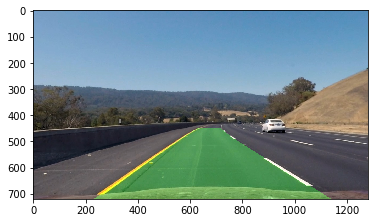

In [32]:
main()

NameError: name 'result' is not defined